# 1. I/O Module (FullWaveUST.io)
## 1.1 load_mat(path)
#### Purpose
Read MATLAB v7.3+ files into Python, automatically fixing MATLAB→NumPy row/column conventions.

#### Signature
```python
load_mat(path: str | Path) → dict[str, np.ndarray]
```

#### Parameters
* path
Path to the .mat file.

#### Behavior
1.	Opens HDF5-backed .mat via h5py.
2.	Lists variables and reports progress.
3.	For each dataset:
- Reads into a NumPy array.
- If 2D or higher, transposes to restore MATLAB row-major ordering.
- Converts to Fortran-order (column-major) for consistency, then squeezes singleton dims.
4.	Returns a dict mapping variable names → arrays.

## 1.2 save_results(path, results_dict)
#### Purpose
Write Python arrays back to a .mat file for use in MATLAB, with optional compression.


#### Signature
```python
save_results(
    path: str | Path,
    results_dict: dict[str, array-like]
) → None
```
#### Parameters
- path
Destination .mat file path; intermediate directories are created if needed.
- results_dict
Mapping from variable names to array-like objects (ndarrays, lists, etc.).


#### Behavior
- Uses scipy.io.savemat with compression to write out all entries in results_dict.

# 2. Geometry Module (FullWaveUST.geometry)
All geometry classes inherit from the base Geometry, which handles common metadata.
Defining and managing various geometric information, including the acquisition geometry of sensor arrays and the image geometry of reconstruction grids.

## 2.1 Geometry Base Class
#### Purpose
Abstract container for spatial metadata: array shape and physical extent.

#### Attributes
- shape: tuple[int, …]
- extent: tuple[float, …] | None

#### Key Methods
- copy() → deep copy of the geometry.
- __repr__() → human-readable summary.

## 2.2 AcquisitionGeometry

#### Purpose
Describe a linear( or ring) array of transducers (Tx/Rx), compute inter-element time-of-flight (TOF).


#### Constructor
```python
AcquisitionGeometry(
    positions: array-like (2 × N),
    c_geom: float
)
```
#### Attributes
- positions: ndarray (2 × N) -> sensor positions
- c_geom: float -> sound velocity constants

#### Key Methods
- from_dict(info: dict[str,Any]) → convenience ctor expecting keys "positions" and "c_geom".
- compute_geometric_tofs() →
Returns an (N, N) array of TOFs (distance/c_geom) between every transmitter (column) and receiver (row).
- n_elements() → Returns total number of transducer elements (Tx == Rx).


## 2.3 ImageGeometry
#### Purpose
Define a 2D imaging grid by explicit x and y coordinate vectors.

#### Constructor
```python
ImageGeometry(
    xi: array-like (Nx,),
    yi: array-like (Ny,)
)
```
#### Attributes
- xi: ndarray (Nx,)
- yi: ndarray (Ny,)
- Inherited shape = (Ny, Nx)
- Inherited extent = (min(xi), max(xi), min(yi), max(yi))


#### Key Properties & Methods
- nx, ny → number of grid points along x/y.
- spacing → tuple (dx, dy) as mean grid step sizes.
- meshgrid() → returns 2D coordinate arrays of shape (Ny, Nx) for plotting or evaluation.

# 3. Data Container Module (FullWaveUST.data)
All containers subclass DataContainer, which centralizes array-geometry pairing and common operations.


## 3.1 DataContainer Base Class
#### Purpose
Wrap a NumPy array with a Geometry object, providing cloning, I/O, indexing, FFT, arithmetic, and reductions.

#### Constructor
```python
DataContainer(
    array: np.ndarray,
    geometry: Geometry
)
```
#### Attributes
- array : np.ndarray
    The raw data array.
- geometry : object
    Geometry object describing the array coordinates.
- ctx : dict
    Context dictionary for additional metadata (default empty).

#### Key Methods
- **`clone()` / `copy()`**
  Return a deep copy (same subclass) with its own array and geometry.

- **`save(path)`**
  Save `array` to `.npy` or `.npz` (if path ends with `.npz`).

- **`visualize(**kwargs)`**
  Show 2D image of `array` using `geometry.extent`, passing kwargs to `imshow`.

- **`reshape(new_shape)`**
  Return new container with `array` reshaped to `new_shape`.

- **`get_slice(index, axis=0)`**
  Return new container containing `array` slice at `index` along `axis`.

- **`reorder(order)`**
  Return new container with axes permuted by `order`.

- **`pad(pad_width, mode, **kwargs)`**
  Return new container with `array` padded via `np.pad`.

- **`crop(slices)`**
  Return new container with `array` cropped by `slices`.

- **`fft(axis=-1)` / `ifft(axis=-1)`**
  Return new container with FFT / IFFT applied along `axis`.

- **Arithmetic (`+`, `-`, `*`, `/`, unary `-`)**
  Elementwise ops return new container; supports scalars or other containers.

- **Reductions (`sum`, `mean`, `max`, `min`)**
  Compute on `array` and return a NumPy scalar or array.

## 3.2 AcquisitionData
#### Purpose
Specialize DataContainer for time- or frequency-domain acquisition data.


#### Constructor
```python
AcquisitionData(
    array: np.ndarray,
    time: np.ndarray,
    geometry: AcquisitionGeometry
    freqs: np.ndarray | None = None
)
```
#### Attributes
- array : np.ndarray
  Time‐domain: shape (Tx, Rx, T)
  Frequency‐domain: shape (Tx, Rx, F)
- time : np.ndarray
    Time vector of length T; set to None after transforming to frequency.
- geometry : AcquisitionGeometry
    Transmitter/receiver layout and reference speed.
- freqs : np.ndarray | None
    Frequency vector of length F; None if in time domain.

#### Key Methods
- get_array() → np.ndarray
Return the raw array.
- slice_frequency(f_idx: int) → np.ndarray
For freq‐domain data, extract slice array[:, :, f_idx] (shape (Tx, Rx)).


## 3.3 ImageData
#### Purpose
Container for 2D images with update history.

#### Constructor
```python
ImageData(
    array: np.ndarray,
    geometry: ImageGeometry
)
```
#### Attributes
- array : np.ndarray
Current image (shape (Ny, Nx)).
- geometry : ImageGeometry
Grid coordinates and extent.
- history : list[np.ndarray]
Sequence of past image states, including the initial.

#### Key Methods
- update(new_array: np.ndarray) → None
Replace array with new_array and append to history.
- visualize(idx: int = -1, **kwargs) → None
Display history[idx] via imshow with geometry.extent; pass kwargs (e.g. cmap).
- save(path: str) → None
Save current and full history into a single .npz file (current, history arrays).

In [2]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt

from FullWaveUST.io.load_mat       import load_mat
from FullWaveUST.io.save_results   import save_results
from FullWaveUST.geometry.acquisition_geometry import AcquisitionGeometry
from FullWaveUST.geometry.image_geometry       import ImageGeometry
from FullWaveUST.data.acquisition_data         import AcquisitionData
from FullWaveUST.data.image_data               import ImageData

## Generate a Synthetic Acquisition

We place 3 sensor elements randomly in a plane and simulate full pairwise transmissions. Each channel receives a unit impulse at its geometric TOF, with added Gaussian noise.

In [5]:
# define time axis
T = 200
time = np.linspace(0, 1.0, T)    # 200 samples

# random Tx/Rx geometry
positions = np.random.rand(2, 3) * 100.0   # 3 transmitters, 2 rows [x; y]
c_geom    = 1540.0                         # propagation speed
acq_geom  = AcquisitionGeometry(positions, c_geom)

# compute TOF and reorder to (Tx, Rx)
tof = acq_geom.compute_geometric_tofs()
Tx, Rx = tof.shape

# build raw data directly in shape (Tx, Rx, T)
raw = np.zeros((Tx, Rx, T))
for tx in range(Tx):
    for rx in range(Rx):
        # find nearest time sample to this channel's TOF
        idx = np.argmin(np.abs(time - tof[tx, rx]))
        raw[tx, rx, idx] = 1.0

# add noise
raw += 0.05 * np.random.randn(Tx, Rx, T)

# wrap in AcquisitionData
acq_data = AcquisitionData(array=raw.copy(), time=time, geometry=acq_geom)

print("acq_data.array.shape:", acq_data.array.shape)  # (Tx, Rx, T)
print("First TOF matrix (Tx, Rx):\n", tof)

acq_data.array.shape: (3, 3, 200)
First TOF matrix (Tx, Rx):
 [[0.         0.05384155 0.04143286]
 [0.05384155 0.         0.03027116]
 [0.04143286 0.03027116 0.        ]]


## Create & Inspect an Image Grid

Define a 2D grid of 50×40 points over a 10×8 mm region, visualize the mesh.

Image grid shape: (40, 50)
Extent: (-5.0, 5.0, -4.0, 4.0)
Grid spacing dx=0.20, dy=0.21


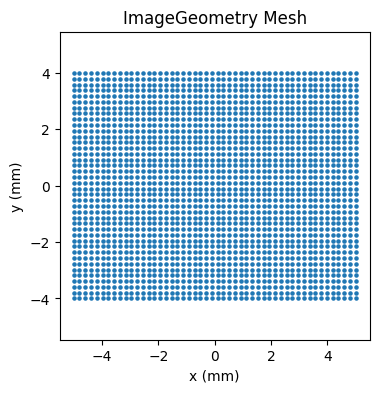

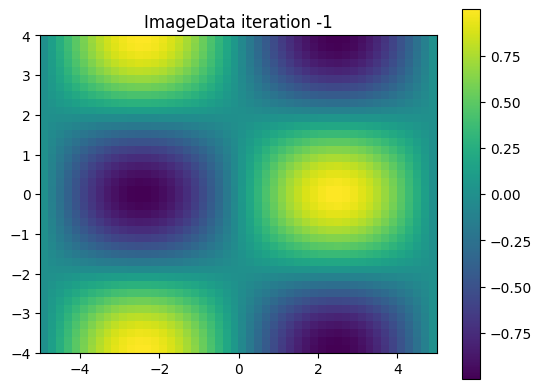

In [6]:
# define x/y coords
xi = np.linspace(-5, 5, 50)
yi = np.linspace(-4, 4, 40)
img_geom = ImageGeometry(xi, yi)

print("Image grid shape:", img_geom.shape)
print("Extent:", img_geom.extent)
dx, dy = img_geom.spacing
print(f"Grid spacing dx={dx:.2f}, dy={dy:.2f}")

# plot mesh
X, Y = img_geom.meshgrid()
plt.figure(figsize=(4,4))
plt.scatter(X.ravel(), Y.ravel(), s=5)
plt.title("ImageGeometry Mesh")
plt.xlabel("x (mm)"); plt.ylabel("y (mm)")
plt.axis("equal")
plt.show()

# wrap a dummy image & visualize
dummy_image = np.sin(2*np.pi*X/10) * np.cos(2*np.pi*Y/8)
img_data = ImageData(dummy_image, img_geom)
img_data.visualize()